# Part (b): Pre-trained Model Classification

- **Part 1 — Load Model, Preprocessing, _and_ Test Loader:** load pretrained **ResNet-18 (ImageNet)**, get its transforms + label names, then build a `DataLoader` for `test/CLASS/*` (images + ground-truth class ids from folder names).  
  > The assignment didn’t require a DataLoader explicitly; But I added it because it’s the standard PyTorch way to iterate a dataset efficiently and correctly (it batches images, pairs each image with its label from the folder name, and keeps order stable). Based on my research for how to do this assignment, it seemed like a cleaner altnernative to manually looping the files.

- **Part 2 — Inference:** run the model; collect ground-truth class ids and **top-1** ImageNet label names from the cleaned DataLoader batches defined in Part 1. 

- **Part 3 — Confusion Table:** build a <u>rectangular</u> confusion table that shows, for each bird class, how often ResNe-18 associated them with each ImageNet label. It’s rectangular because rows (your 20 bird classes) ≠ columns (ImageNet’s 1000 labels). We keep only the ImageNet labels that actually appeared (`unique_pred_labels`).

- **Part 4 — Summaries & Plots:** print the per-class “mode” (most frequent predicted ImageNet label) and show full/Top-K heatmaps.

- **Part 5 — Standalone Predictions:** print **Top-5** ImageNet guesses for files in `images to predict/`.



=== Per-class most frequent ImageNet label (mode) ===
ABBOTTS BABBLER              -> ringlet  (n=1)
ABBOTTS BOOBY                -> spoonbill  (n=2)
ABYSSINIAN GROUND HORNBILL   -> hornbill  (n=5)
AFRICAN CROWNED CRANE        -> crane bird  (n=5)
AFRICAN EMERALD CUCKOO       -> jacamar  (n=4)
AFRICAN FIREFINCH            -> house finch  (n=3)
AFRICAN OYSTER CATCHER       -> oystercatcher  (n=5)
AFRICAN PIED HORNBILL        -> hornbill  (n=5)
AFRICAN PYGMY GOOSE          -> drake  (n=3)
ALBATROSS                    -> albatross  (n=5)
ALBERTS TOWHEE               -> bulbul  (n=1)
ALEXANDRINE PARAKEET         -> lorikeet  (n=3)
ALPINE CHOUGH                -> oystercatcher  (n=1)
ALTAMIRA YELLOWTHROAT        -> goldfinch  (n=4)
AMERICAN AVOCET              -> dowitcher  (n=2)
AMERICAN BITTERN             -> bittern  (n=5)
AMERICAN COOT                -> American coot  (n=4)
AMERICAN FLAMINGO            -> flamingo  (n=5)
AMERICAN GOLDFINCH           -> goldfinch  (n=5)
AMERICAN KESTREL

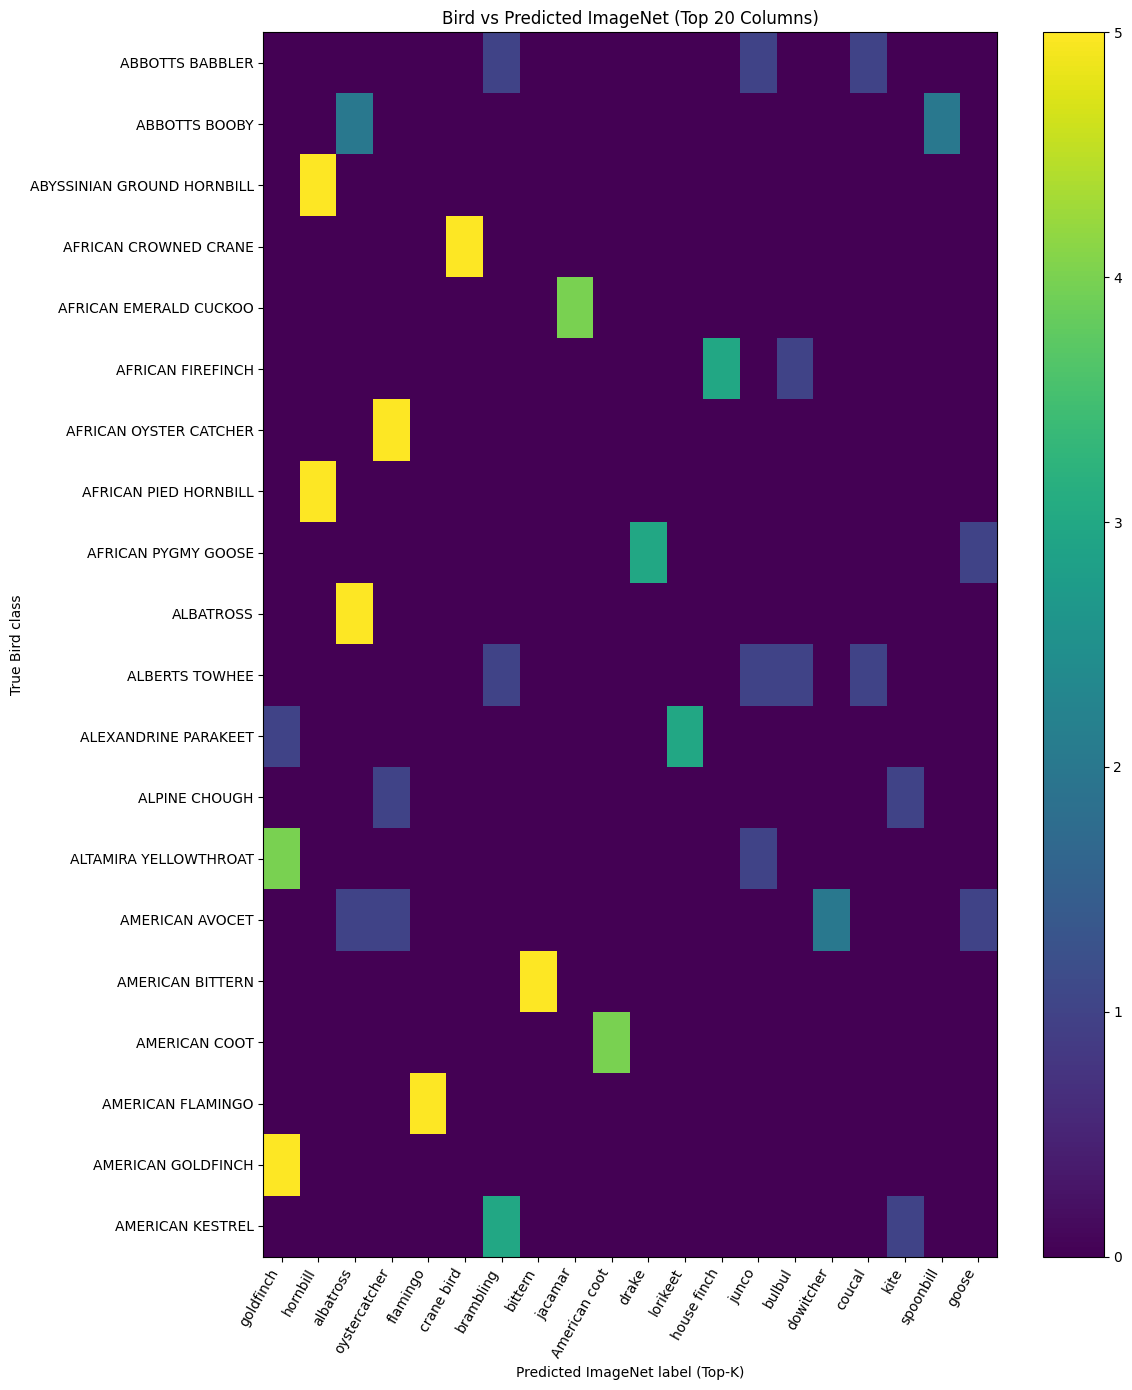


=== Predictions for images_to_predict (top-5) ===

C:\Users\SeenB\Downloads\5600_a2\images to predict\1.jpg
   0.9998  crane bird
   0.0001  goose
   0.0000  little blue heron
   0.0000  vulture
   0.0000  black stork

C:\Users\SeenB\Downloads\5600_a2\images to predict\2.jpg
   0.9419  crane bird
   0.0189  vulture
   0.0114  indri
   0.0037  ostrich
   0.0032  Madagascar cat

C:\Users\SeenB\Downloads\5600_a2\images to predict\3.jpg
   0.9868  crane bird
   0.0035  vulture
   0.0026  black stork
   0.0018  hornbill
   0.0014  goose

C:\Users\SeenB\Downloads\5600_a2\images to predict\4.jpg
   0.9979  crane bird
   0.0003  little blue heron
   0.0003  red-breasted merganser
   0.0002  white stork
   0.0002  limpkin

C:\Users\SeenB\Downloads\5600_a2\images to predict\5.jpg
   0.9897  crane bird
   0.0019  chickadee
   0.0017  vulture
   0.0017  red-breasted merganser
   0.0006  little blue heron

C:\Users\SeenB\Downloads\5600_a2\images to predict\6.jpg
   0.9893  bald eagle
   0.0097  ki

In [10]:
from pathlib import Path
import glob
from collections import defaultdict, Counter
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, models
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

BASE        = Path(r"C:\Users\SeenB\Downloads\5600_a2")
TEST_DIR    = BASE / "test"
PREDICT_DIR = BASE / "images to predict"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================================#
#                                                           #
# [1] Load Model, Preprocessing, AND Test Loader            #
#     (ResNet-18 ImageNet + transforms + DataLoader)        #
#                                                           #
# ==========================================================#
weights         = torchvision.models.ResNet18_Weights.DEFAULT
preprocess      = weights.transforms()                       # resize/crop/normalize that matches weights
imagenet_labels = weights.meta["categories"]                 # 1000 (human-readable) ImageNet class names
model           = models.resnet18(weights=weights).to(device)
model.eval()

test_ds      = datasets.ImageFolder(TEST_DIR, transform=preprocess)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)
bird_classes = test_ds.classes

# ==========================================================#
#                                                           #
# [2] Inference (collect truths + predicted top-1 names)    #
#                                                           #
# ==========================================================#
y_true       = [] # ground-truth bird class indices
y_pred_names = [] # predicted ImageNet class names

with torch.inference_mode():
    for images, targets in test_loader: 
        images = images.to(device)
        logits = model(images)
        top1_idx = logits.argmax(dim=1).cpu().tolist()
        
        y_true.extend(targets.tolist())
        y_pred_names.extend([imagenet_labels[i] for i in top1_idx])

# ==========================================================#
#                                                           #
# [3] Confusion Table (rectangular birds × ImageNet-used)   #
#                                                           #
# ==========================================================#
unique_pred_labels = sorted(set(y_pred_names))
label_to_col = {name: i for i, name in enumerate(unique_pred_labels)}
y_pred_cols = [label_to_col[n] for n in y_pred_names]

count_matrix = np.zeros((len(bird_classes), len(unique_pred_labels)), dtype=int)
for true, col in zip(y_true, y_pred_cols):
    count_matrix[true, col] += 1

count_matrix_dataframe = pd.DataFrame(count_matrix, index=bird_classes, columns=unique_pred_labels)

# ==========================================================#
#                                                           #
# [4] Summaries & Plots (modes + full/Top-K heatmaps)       #
#                                                           #
# ==========================================================#
indices_by_class = defaultdict(list)
for i, cls_idx in enumerate(y_true):
    indices_by_class[cls_idx].append(i)

per_class_modes = []
for cls_idx, idxs in indices_by_class.items():
    names = [y_pred_names[i] for i in idxs]
    lbl, cnt = Counter(names).most_common(1)[0]
    per_class_modes.append((bird_classes[cls_idx], lbl, cnt))

modes_df = pd.DataFrame(per_class_modes, columns=["bird_class", "most_frequent_imagenet_label", "count"]) \
             .sort_values("bird_class")

print("\n=== Per-class most frequent ImageNet label (mode) ===")
for _, row in modes_df.iterrows():
    print(f"{row['bird_class'][:28]:28s} -> {row['most_frequent_imagenet_label']}  (n={row['count']})")

# Top-K columns (cleaner heatmap)
K = min(20, count_matrix_dataframe.shape[1])
topk_cols = count_matrix_dataframe.sum(axis=0).sort_values(ascending=False).head(K).index
print(f"\nTop {K} predicted ImageNet labels overall:")
print(count_matrix_dataframe[topk_cols].sum(axis=0).sort_values(ascending=False))

# Top-K heatmap (with full axis labels; no shortening)
cm_topk = count_matrix_dataframe[topk_cols]

fig, ax = plt.subplots(figsize=(max(12, 0.6*cm_topk.shape[1]), 0.5*cm_topk.shape[0] + 4))
im = ax.imshow(cm_topk.values, aspect='auto')

ax.set_title(f"Bird vs Predicted ImageNet (Top {K} Columns)")
ax.set_xlabel("Predicted ImageNet label (Top-K)")
ax.set_ylabel("True Bird class")

# full labels on both axes
ax.set_xticks(range(len(cm_topk.columns)))
ax.set_xticklabels(list(cm_topk.columns), rotation=60, ha='right')
ax.set_yticks(range(len(cm_topk.index)))
ax.set_yticklabels(list(cm_topk.index))

fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

# ==========================================================#
#                                                           #
# [5] Standalone Predictions (Top-5 for 5 images)           #
#                                                           #
# ==========================================================#
def topk_preds_for_image(img_path, k=5):
    img = Image.open(img_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.inference_mode():
        probs = model(x).softmax(dim=1).cpu().numpy()[0]
    topk_idx = np.argsort(-probs)[:k]
    return [(imagenet_labels[i], float(probs[i])) for i in topk_idx]

predict_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"):
    predict_paths += glob.glob(str(PREDICT_DIR / ext))

print("\n=== Predictions for images_to_predict (top-5) ===")
for p in predict_paths:
    print(f"\n{p}")
    for name, prob in topk_preds_for_image(p, k=5):
        print(f"  {prob:7.4f}  {name}")


# Part (c): Fine-tuning a Model on given Bird Classes

- **Part 1 — Data & Transforms:** build `DataLoader`s for `train/`, `valid/`, and `test`. I use **augmentation** on `train/` (random crop/flip) to improve generalization, and a **stable eval transform** (resize → center-crop → normalize) for `valid/` and `test`.

- **Part 2 — Model Head (20-class) & Freezing Strategy:** I start from a pretrained **ResNet-18** and **replace** the 1000-class final layer with a **20-class** layer. I begin by **freezing** the backbone and training only the new head (quick baseline).

- **Part 3 — Training Loop:** I train with `CrossEntropyLoss` and Adam/SGD at a small learning rate, tracking **training loss/accuracy** each epoch.

- **Part 4 — Validation & Checkpointing:** I evaluate on `valid/` each epoch and keep the **best validation** model (early stopping by selection).

- **Part 5 — Test Evaluation (Square Matrix):** I run the best model on `test/` and compute a **20×20 confusion matrix** (rows = true bird, cols = predicted bird).  
  I report **overall accuracy** and (if space allows) a **classification report** with per-class precision/recall/F1.

- **Part 6 — Brief Comparison to Part (b):** I note how fine-tuning changed results vs. the zero-shot ImageNet model (which produced a **rectangular** table in a different label space).  
  Optionally, I show updated predictions for the five “images to predict,” now labeled with **my** 20 classes.



=== Training (Part c) ===
Epoch 01 | train_loss 1.8179 | train_acc 0.597 | val_acc 0.900
Epoch 02 | train_loss 0.6619 | train_acc 0.912 | val_acc 0.940
Epoch 03 | train_loss 0.4131 | train_acc 0.941 | val_acc 0.970
Epoch 04 | train_loss 0.3239 | train_acc 0.954 | val_acc 0.970
Epoch 05 | train_loss 0.3109 | train_acc 0.959 | val_acc 0.970

Test accuracy (Part c): 0.960

=== Classification report (Part c) ===
                            precision    recall  f1-score   support

           ABBOTTS BABBLER      0.750     0.600     0.667         5
             ABBOTTS BOOBY      1.000     1.000     1.000         5
ABYSSINIAN GROUND HORNBILL      1.000     1.000     1.000         5
     AFRICAN CROWNED CRANE      1.000     1.000     1.000         5
    AFRICAN EMERALD CUCKOO      1.000     1.000     1.000         5
         AFRICAN FIREFINCH      0.714     1.000     0.833         5
    AFRICAN OYSTER CATCHER      1.000     1.000     1.000         5
     AFRICAN PIED HORNBILL      1.000     

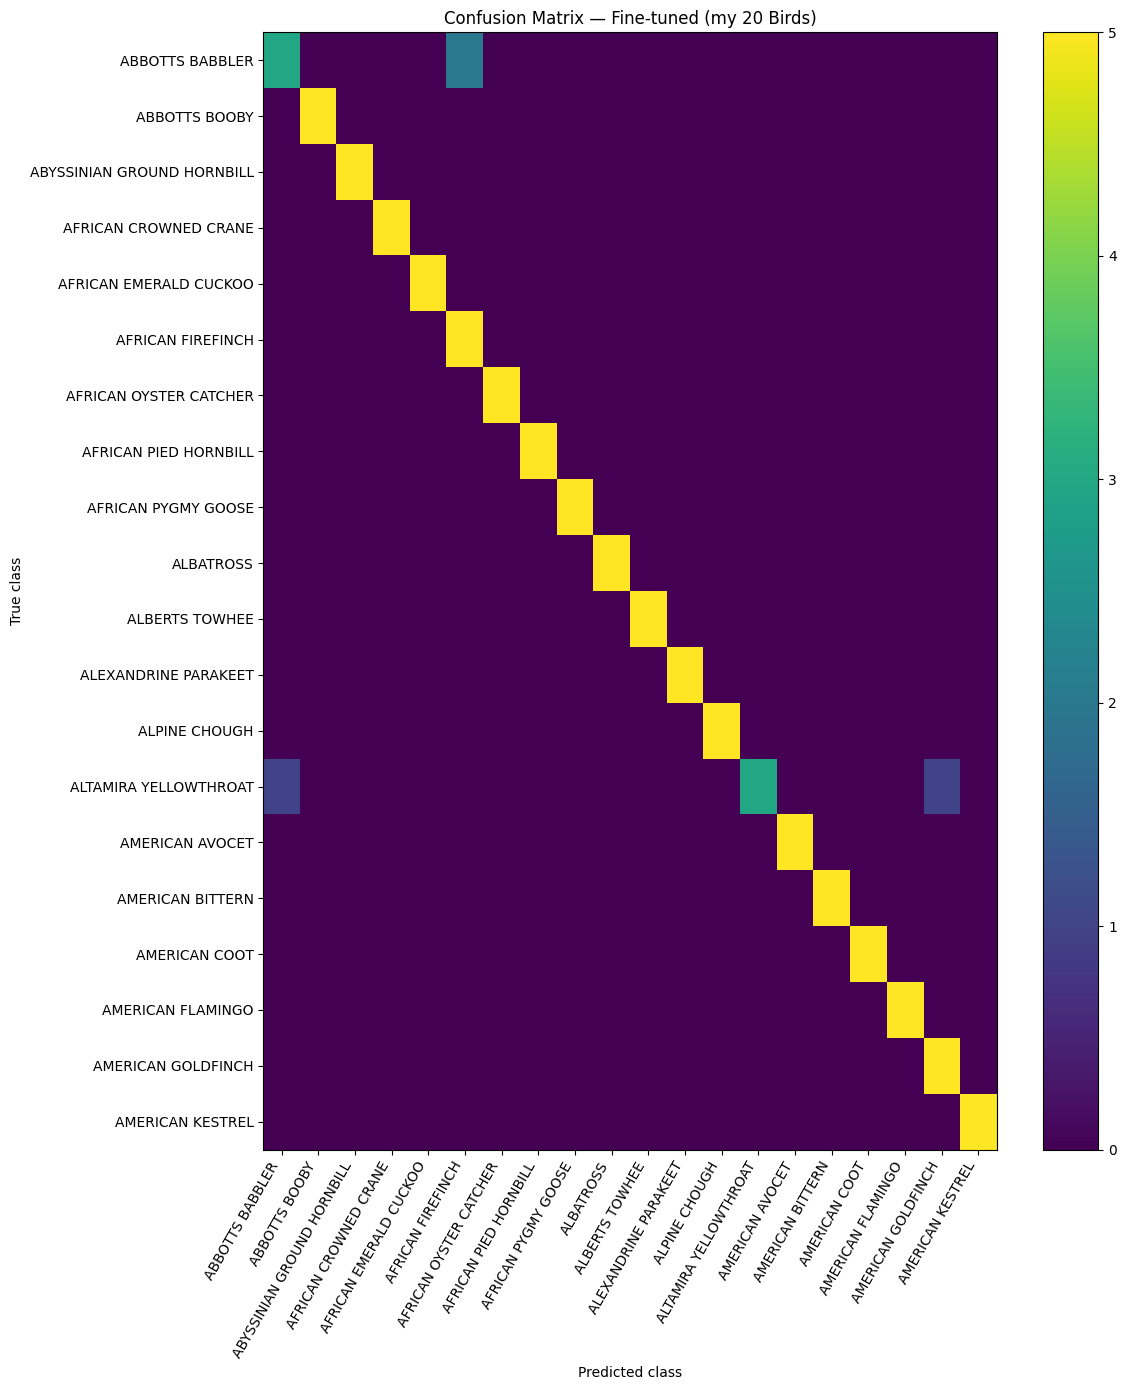

In [ ]:
from torch import nn, optim
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================================#
#                                                           #
# [1] Data & Transforms (train/valid/test loaders)          #
#     - train: aug (crop/flip)                              #
#     - valid/test: eval (resize→center-crop→normalize)     #
#                                                           #
# ==========================================================#

TRAIN_DIR = BASE / "train"
VALID_DIR = BASE / "valid"
TEST_DIR_C = BASE / "test"

IMAGENET_MEAN = (0.485, 0.456, 0.406) # standard ImageNet normalization
IMAGENET_STD  = (0.229, 0.224, 0.225) # standard ImageNet normalization

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds_c = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
valid_ds_c = datasets.ImageFolder(VALID_DIR, transform=eval_tf)
test_ds_c  = datasets.ImageFolder(TEST_DIR_C, transform=eval_tf)

assert train_ds_c.classes == valid_ds_c.classes == test_ds_c.classes, "Class order mismatch across splits."

bird_classes_c = train_ds_c.classes
NUM_CLASSES = len(bird_classes_c)

train_loader_c = DataLoader(train_ds_c, batch_size=64, shuffle=True,  num_workers=0)
valid_loader_c = DataLoader(valid_ds_c, batch_size=64, shuffle=False, num_workers=0)
test_loader_c  = DataLoader(test_ds_c,  batch_size=64, shuffle=False, num_workers=0)

# ==========================================================#
#                                                           #
# [2] Model Head (1000→20) & Freezing Strategy              #
#     - start from pretrained resnet18                      #
#     - replace final fc with 20-class layer                #
#     - freeze backbone (quick baseline)                    #
#                                                           #
# ==========================================================#
model_c = models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT).to(device)
in_feats = model_c.fc.in_features
model_c.fc = nn.Linear(in_feats, NUM_CLASSES).to(device)

# freeze all except the new head
for name, p in model_c.named_parameters():
    p.requires_grad = name.startswith("fc")

criterion_c = nn.CrossEntropyLoss()
optimizer_c = optim.AdamW(filter(lambda p: p.requires_grad, model_c.parameters()),
                          lr=1e-3, weight_decay=1e-4)
scheduler_c = optim.lr_scheduler.StepLR(optimizer_c, step_size=3, gamma=0.1)

# ==========================================================#
#                                                           #
# [3] Training Loop (track train loss/acc)                  #
#     + Validation each epoch (keep best model)             #
#                                                           #
# ==========================================================#
EPOCHS_C = 5
best_val_acc = 0.0
best_state = None

print("\n=== Training (Part c) ===")
for epoch in range(1, EPOCHS_C + 1):
    # ---- training ----
    model_c.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_loader_c:
        x, y = x.to(device), y.to(device)
        optimizer_c.zero_grad()
        logits = model_c(x)
        loss = criterion_c(logits, y)
        loss.backward()
        optimizer_c.step()

        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += y.size(0)

    train_loss = loss_sum / total
    train_acc  = correct / total

    # ---- validate ----
    model_c.eval()
    v_total, v_correct = 0, 0
    with torch.inference_mode():
        for x, y in valid_loader_c:
            x, y = x.to(device), y.to(device)
            logits = model_c(x)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)
    val_acc = v_correct / v_total
    scheduler_c.step()

    print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | train_acc {train_acc:.3f} | val_acc {val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu() for k, v in model_c.state_dict().items()}

# restore best validation weights (if any)
if best_state is not None:
    model_c.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# ==========================================================#
#                                                           #
# [4] Test Evaluation (square 20×20 confusion matrix)       #
#     - accuracy + classification report                    #
#     - heatmap with class labels on both axes              #
#                                                           #
# ==========================================================#
model_c.eval()
y_true_idx_c, y_pred_idx_c = [], []
with torch.inference_mode():
    for x, y in test_loader_c:
        x = x.to(device)
        pred = model_c(x).argmax(1).cpu().tolist()
        y_pred_idx_c.extend(pred)
        y_true_idx_c.extend(y.tolist())

acc_c = (np.array(y_true_idx_c) == np.array(y_pred_idx_c)).mean()
print(f"\nTest accuracy (Part c): {acc_c:.3f}")

cm_sq = confusion_matrix(y_true_idx_c, y_pred_idx_c, labels=list(range(NUM_CLASSES)))
cm_sq_df = pd.DataFrame(cm_sq, index=bird_classes_c, columns=bird_classes_c)

print("\n=== Classification report (Part c) ===")
print(classification_report(y_true_idx_c, y_pred_idx_c, target_names=bird_classes_c, digits=3))

fig, ax = plt.subplots(figsize=(max(12, 0.6*NUM_CLASSES), 0.5*NUM_CLASSES + 4))
im = ax.imshow(cm_sq_df.values, aspect='auto')

ax.set_title("Confusion Matrix — Fine-tuned (my 20 Birds)")
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
ax.set_xticks(range(len(cm_sq_df.columns)))
ax.set_xticklabels(list(cm_sq_df.columns), rotation=60, ha='right')
ax.set_yticks(range(len(cm_sq_df.index)))
ax.set_yticklabels(list(cm_sq_df.index))

fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()


# Part (d): Unfreeze and fine-tune deeper layers

- **Part 1 — Unfreezing Plan:** I take the best Part (c) model and **unfreeze** higher-level layers (e.g., `layer4` + the `fc` head) so the backbone can adapt to my bird dataset.
- **Part 2 — Optimizer & LR:** I re-create the optimizer with a **smaller learning rate** (fine-tuning is delicate) and keep weight decay modest.
- **Part 3 — Short Fine-tune:** I run a few more epochs with validation each epoch and keep the **best validation** checkpoint.
- **Part 4 — Test & Confusion Matrix:** I evaluate on `test/`, report accuracy, and plot a **square** confusion matrix (my 20 classes on both axes) to compare against Part (c).
> Rationale: unfreezing lets the model adjust its higher-level features from generic ImageNet to my bird species. Small LR + brief training helps avoid forgetting.



(Reference) Part (c) test accuracy: 0.960

=== Fine-tuning (Part d) ===
Epoch 01 | train_loss 0.1496 | train_acc 0.965 | val_acc 0.980
Epoch 02 | train_loss 0.0329 | train_acc 0.993 | val_acc 0.980
Epoch 03 | train_loss 0.0149 | train_acc 0.997 | val_acc 0.980

Test accuracy (Part d): 0.970
Δ vs Part (c): +0.010

=== Classification report (Part d) ===
                            precision    recall  f1-score   support

           ABBOTTS BABBLER      1.000     0.800     0.889         5
             ABBOTTS BOOBY      1.000     0.800     0.889         5
ABYSSINIAN GROUND HORNBILL      1.000     1.000     1.000         5
     AFRICAN CROWNED CRANE      1.000     1.000     1.000         5
    AFRICAN EMERALD CUCKOO      1.000     1.000     1.000         5
         AFRICAN FIREFINCH      0.833     1.000     0.909         5
    AFRICAN OYSTER CATCHER      1.000     1.000     1.000         5
     AFRICAN PIED HORNBILL      1.000     1.000     1.000         5
       AFRICAN PYGMY GOOSE      

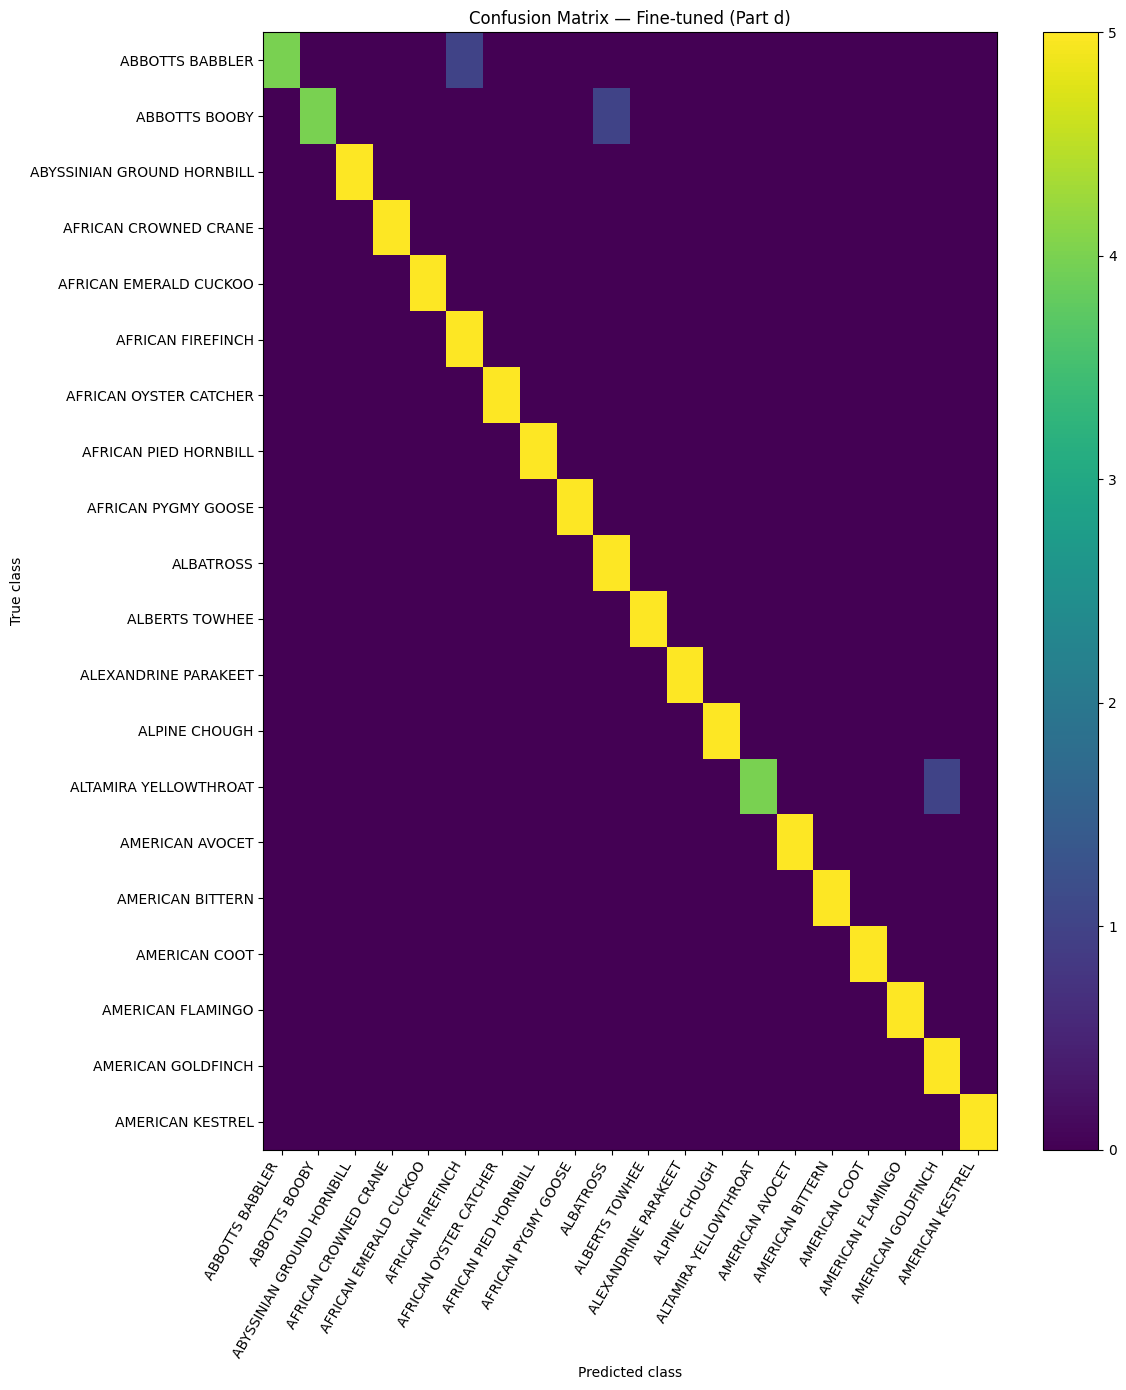

In [ ]:
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================================#
#                                                           #
# [1] Unfreezing Plan                                       #
#     - unfreeze resnet18.layer4 and fc                     #
#                                                           #
# ==========================================================#
for name, p in model_c.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        p.requires_grad = True
    else:
        p.requires_grad = False

# ==========================================================#
#                                                           #
# [2] Optimizer & LR (smaller for fine-tuning)              #
#                                                           #
# ==========================================================#

optimizer_d = optim.AdamW(
    (p for p in model_c.parameters() if p.requires_grad),
    lr=3e-4, weight_decay=1e-4
)
scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=3, gamma=0.5)
criterion_d = nn.CrossEntropyLoss()

try:
    print(f"\n(Reference) Part (c) test accuracy: {acc_c:.3f}")
except NameError:
    pass

# ==========================================================#
#                                                           #
# [3] Short Fine-tune (keep best validation model)          #
#                                                           #
# ==========================================================#
EPOCHS_D = 3 # number of epochs for Part d
best_val_acc_d = 0.0
best_state_d = None

print("\n=== Fine-tuning (Part d) ===")
for epoch in range(1, EPOCHS_D + 1):
    # ---- train ----
    model_c.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_loader_c:
        x, y = x.to(device), y.to(device)
        optimizer_d.zero_grad()
        logits = model_c(x)
        loss = criterion_d(logits, y)
        loss.backward()
        optimizer_d.step()

        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += y.size(0)

    train_loss = loss_sum / total
    train_acc  = correct / total

    # ---- validate ----
    model_c.eval()
    v_total, v_correct = 0, 0
    with torch.inference_mode():
        for x, y in valid_loader_c:
            x, y = x.to(device), y.to(device)
            logits = model_c(x)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)
    val_acc = v_correct / v_total
    scheduler_d.step()

    print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | train_acc {train_acc:.3f} | val_acc {val_acc:.3f}")

    if val_acc > best_val_acc_d:
        best_val_acc_d = val_acc
        best_state_d = {k: v.cpu() for k, v in model_c.state_dict().items()}

# Restore best validation weights from Part d
if best_state_d is not None:
    model_c.load_state_dict({k: v.to(device) for k, v in best_state_d.items()})

# ==========================================================#
#                                                           #
# [4] Test & Confusion Matrix (my label space)              #
#     - accuracy + classification report                    #
#     - labels shown on both axes                           #
#                                                           #
# ==========================================================#
model_c.eval()
y_true_idx_d, y_pred_idx_d = [], []
with torch.inference_mode():
    for x, y in test_loader_c:
        x = x.to(device)
        pred = model_c(x).argmax(1).cpu().tolist()
        y_pred_idx_d.extend(pred)
        y_true_idx_d.extend(y.tolist())

acc_d = (np.array(y_true_idx_d) == np.array(y_pred_idx_d)).mean()
print(f"\nTest accuracy (Part d): {acc_d:.3f}")
try:
    print(f"Δ vs Part (c): {acc_d - acc_c:+.3f}")
except NameError:
    pass

cm_d = confusion_matrix(y_true_idx_d, y_pred_idx_d, labels=list(range(NUM_CLASSES)))
cm_d_df = pd.DataFrame(cm_d, index=bird_classes_c, columns=bird_classes_c)

print("\n=== Classification report (Part d) ===")
print(classification_report(y_true_idx_d, y_pred_idx_d, target_names=bird_classes_c, digits=3))

# Heatmap with full class labels on both axes
fig, ax = plt.subplots(figsize=(max(12, 0.6*NUM_CLASSES), 0.5*NUM_CLASSES + 4))
im = ax.imshow(cm_d_df.values, aspect='auto')

ax.set_title("Confusion Matrix — Fine-tuned (Part d)")
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")

ax.set_xticks(range(len(cm_d_df.columns)))
ax.set_xticklabels(list(cm_d_df.columns), rotation=60, ha='right')
ax.set_yticks(range(len(cm_d_df.index)))
ax.set_yticklabels(list(cm_d_df.index))

fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()
